In [3]:
import openai
import os

## Adding new tools

In [4]:
prompt = 'hello what is your name?'

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=[{"role": "user", "content": prompt}],
)

print(completion.choices[0].message.content)

Hello! I am an AI language model developed by OpenAI called GPT-3, so I don't have a personal name. You can refer to me as Assistant or AI. How can I assist you today?


In [28]:
from pydantic import create_model
import inspect, json
from inspect import Parameter


def schema(f):
    kw = {n:(o.annotation, ... if o.default==Parameter.empty else o.default)
          for n,o in inspect.signature(f).parameters.items()}
    s = create_model(f'Input for `{f.__name__}`', **kw).schema()
    return dict(name=f.__name__, description=f.__doc__, parameters=s)



In [33]:
def sums(a:int, b:int=1):
    "Adds a + b"
    return a + b

def a_b_test(a:int, b:int=1):
    "sets up simulation with a and b parameter sets"
    # add code that does a_b testing in a generalized way
    return a*b

In [34]:
schema(sums)

{'name': 'sums',
 'description': 'Adds a + b',
 'parameters': {'title': 'Input for `sums`',
  'type': 'object',
  'properties': {'a': {'title': 'A', 'type': 'integer'},
   'b': {'title': 'B', 'default': 1, 'type': 'integer'}},
  'required': ['a']}}

In [30]:
function_descriptions = [schema(sums),schema(a_b_test)]

In [13]:
def executor_agent(prompt):
    """Give LLM a given prompt and get an answer."""

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=[{"role": "user", "content": prompt}],
        # add function calling
        functions=function_descriptions,
        function_call="auto",  # specify the function call
    )

    output = completion.choices[0].message
    return output


In [15]:
answer=executor_agent("can you add 2 and 3")

In [16]:
answer

<OpenAIObject at 0x1fb09e5c4a0> JSON: {
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "sums",
    "arguments": "{\n  \"a\": 2,\n  \"b\": 3\n}"
  }
}

In [26]:
eval(answer.function_call.name)(**json.loads(answer.function_call.arguments))

5

In [27]:
executor_agent("can you run an ab test where a is 8 and b is 9")

<OpenAIObject at 0x1fb0a6a7b80> JSON: {
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "a_b_test",
    "arguments": "{\n  \"a\": 8,\n  \"b\": 9\n}"
  }
}

## Adding short term memories to our Agents (remembers some chat history)

In [ ]:
from openai import ChatCompletion,Completion

In [ ]:
aussie_sys = "You are an Aussie LLM that uses Aussie slang and analogies whenever possible."

c = ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "system", "content": aussie_sys},
              {"role": "user", "content": "What is money?"}])

In [ ]:
c = ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "system", "content": aussie_sys},
              {"role": "user", "content": "What is money?"},
              {"role": "assistant", "content": "Well, mate, money is like kangaroos actually."},
              {"role": "user", "content": "Really? In what way?"}])

In [ ]:
def askgpt(user, system=None, model="gpt-3.5-turbo", **kwargs):
    msgs = []
    if system: msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": user})
    return ChatCompletion.create(model=model, messages=msgs, **kwargs)

## Converting Short term memory to long term memory by embedding the chat histories in a vector index

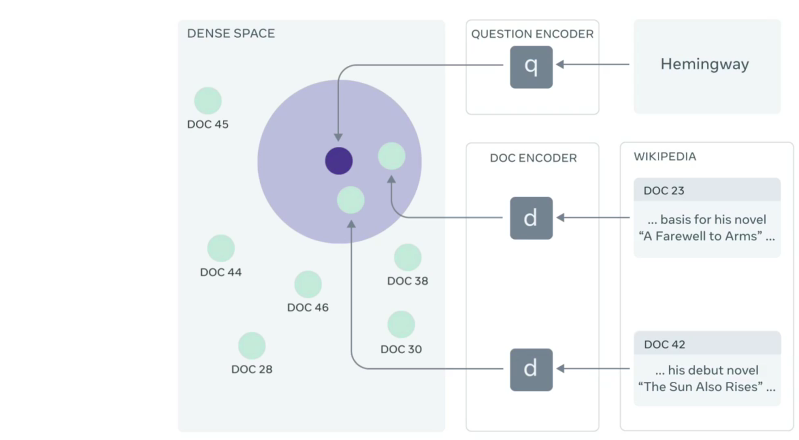

In [ ]:
from langchain.chat_models import ChatOpenAI
# from langchain.agents.agent_types import AgentType
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

In [ ]:
docs = """hi this is supposed to be a docstring"""

In [ ]:
question = "what is in this dcoument?"

In [ ]:
vectorstore = FAISS.from_texts([docs], embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()
chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | model 
    | StrOutputParser()
)
info = chain.invoke(question)

## Adding RAG on planner agent steps